In [28]:
import os
import glob
import shutil
import numpy as np
from PIL import Image
import nibabel as nib
import SimpleITK as sitk
import matplotlib.pyplot as plt

print (os.path.abspath('.'))

/Users/lyraaaaa/Desktop


**t1 / t2 / flair / t1ce**  = four modalities of MRI images

Each of them are a list of t1/t2/flair/t1ce MRI images (210 HGG, 75 LGG)

each image has a shape of (240, 240, 150) as (x, y, z)

x & y 组成大脑的水平横切面，z 代表横切面的 slice

sitk 读出来的 output 是 (z, x, y) 形式

In [ ]:
t1 = glob.glob(r'./BraTS_2018/*/*/*t1.nii.gz')
t2 = glob.glob(r'./BraTS_2018/*/*/*t2.nii.gz')
flair = glob.glob(r'./BraTS_2018/*/*/*flair.nii.gz')
t1ce = glob.glob(r'./BraTS_2018/*/*/*t1ce.nii.gz')
seg = glob.glob(r'./BraTS_2018/*/*/*seg.nii.gz')
csv = glob.glob(r'./BraTS_2018/*.csv')

def read_img(img_path):
    return sitk.GetArrayFromImage(sitk.ReadImage(img_path))

print('No. of images =',len(seg))
print('Shape of each image =',(read_img(seg[0]).shape))

plt.figure (figsize=(12,12))

plt.subplot(1,2,1)
img = (read_img(t1[0])[60]).astype(np.uint8)
plt.imshow(img)

plt.subplot(1,2,2)
img = (read_img(seg[0])[60]).astype(np.uint8)
plt.imshow(img)

In [116]:
dataset_path = 'sample_dataset/train/'

def process(img_p, label_p):
    data = nib.load(img_p).get_fdata()
    labels = nib.load(label_p).get_fdata()
    data = data/np.amax(data)
    data = data.transpose(2, 0, 1)[:,8:232,8:232]   # crop img to (240,240)
    labels[np.where(labels==4)]=3
    labels = labels.transpose(2, 0, 1)[:,8:232,8:232]
    img_name = (img_p.split('/')[-1]).split('_')
    num = img_name[2]
    modality = img_name[-1].split('.')[0]

    print(labels.shape)
    count = 0

    for s in range(len(data)):          # for each slice in a 3D MRI
        image = data[s]
        for x in image:
            if any(y>0 for y in x):     # if the slice has content (≠ 0)
                label = labels[s]       # get coresponding lebal for the slice
                count += 1
                
                name = num + '_'+ modality + '_' + str(s)
                save_dir = os.path.join('sample_dataset/train_npz/', name + '.npz') 
                np.savez(save_dir,image=image,label=label)       # save as npz
                with open('sample_dataset/train.txt', 'a') as f:
                    f.write(name + '\n')
                #print(count)
                break

for patient in os.listdir(dataset_path):
    if not patient.startswith('Brats'):
        continue
    path = os.path.join(dataset_path, patient)
    mri_paths, label_path = [],[]
    for modality in os.listdir(path):
        if modality.endswith('seg.nii.gz'):
            label_path = os.path.join(path, modality)
        elif modality.endswith('nii.gz'):
            mri_paths.append(os.path.join(path, modality))

    for mri in mri_paths:
        process(mri,label_path)
        print(patient)


(155, 224, 224)
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
(155, 224, 224)
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
(155, 224, 224)
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46

(155, 224, 224)


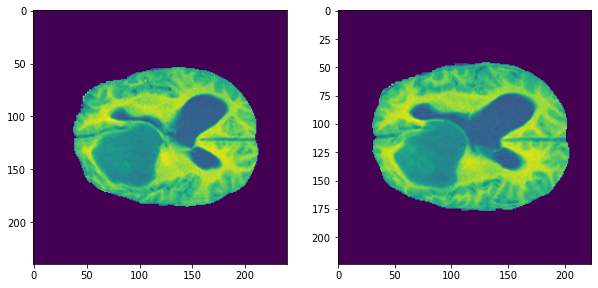

In [115]:
data_path = 'sample_dataset/train/Brats18_TCIA05_444_1/Brats18_TCIA05_444_1_t1.nii.gz'
labels = nib.load(data_path).get_fdata()
labels = labels.transpose(2, 0, 1)

p = labels[:,8:232,8:232]
print(p.shape)

plt.figure (figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(labels[70])

plt.subplot(1,2,2)
plt.imshow(p[75])

In [13]:
import numpy as np
a=np.array([[1,2],[3,4]])
b=np.arange(4)
c=np.arange(5)
np.savez('array_save.npz',img=a,seg = b,c_array=c)
A=np.load('array_save.npz')
print(A['img'])
print(A['seg'])
print(A['c_array'])

In [ ]:
# Split training and validation samples

path = 'sample_dataset/'
traget_path = 'target/'

def slice_MRI(dataset_path):
    t1 = glob.glob(r'./sample_dataset/*/*t1.nii.gz')
    read_img(t1)

    file_no = len(os.listdir(dataset_path))
    for i in range(file_no):
        file = os.listdir(dataset_path)[i]
        if file != '.DS_Store':
            old_path = os.path.join(dataset_path, file)
            if i < file_no*split_rate:
                with open('Splited BraTS/valid.txt', 'a') as f:
                    f.write(file + '\n')
                new_path = os.path.join(traget_path + 'Valid/', file + '/') 
            else:
                with open('Splited BraTS/train.txt', 'a') as f:
                    f.write(file + '\n')
                new_path = os.path.join(traget_path + 'Train/', file + '/') 

            shutil.copytree(old_path,new_path)

train_valid_split(path_HGG)
train_valid_split(path_LGG)